# Multilayer Perceptrons

In :numref:`chap_classification`, we introduced
softmax regression (:numref:`sec_softmax`),
implementing the algorithm from scratch
(:numref:`sec_softmax_scratch`) and using high-level APIs
(:numref:`sec_softmax_concise`). This allowed us to 
train classifiers capable of recognizing
10 categories of clothing from low-resolution images.
Along the way, we learned how to wrangle data,
coerce our outputs into a valid probability distribution,
apply an appropriate loss function,
and minimize it with respect to our model's parameters.
Now that we have mastered these mechanics
in the context of simple linear models,
we can launch our exploration of deep neural networks,
the comparatively rich class of models
with which this book is primarily concerned.


## Hidden Layers

We described affine transformations in
:numref:`subsec_linear_model` as 
linear transformations with added bias.
To begin, recall the model architecture
corresponding to our softmax regression example,
illustrated in  :numref:`fig_softmaxreg`.
This model maps inputs directly to outputs
via a single affine transformation,
followed by a softmax operation.
If our labels truly were related
to the input data by a simple affine transformation,
then this approach would be sufficient.
However, linearity (in affine transformations) is a *strong* assumption.

### Limitations of Linear Models

For example, linearity implies the *weaker*
assumption of *monotonicity*, i.e.,
that any increase in our feature must
either always cause an increase in our model's output
(if the corresponding weight is positive),
or always cause a decrease in our model's output
(if the corresponding weight is negative).
Sometimes that makes sense.
For example, if we were trying to predict
whether an individual will repay a loan,
we might reasonably assume that all other things being equal, 
an applicant with a higher income
would always be more likely to repay
than one with a lower income.
While monotonic, this relationship likely
is not linearly associated with the probability of
repayment. An increase in income from \\$0 to \\$50,000
likely corresponds to a bigger increase
in likelihood of repayment
than an increase from \\$1 million to \\$1.05 million.
One way to handle this might be to post-process our outcome 
such that linearity becomes more plausible,
by using the logistic map (and thus the logarithm of the probability of outcome). 

Note that we can easily come up with examples
that violate monotonicity.
Say for example that we want to predict health as a function 
of body temperature. 
For individuals with a body temperature
above 37°C (98.6°F),
higher temperatures indicate greater risk.
However, for individuals with body temperatures
below 37°C, lower temperatures indicate greater risk!
Again, we might resolve the problem
with some clever preprocessing, such as using the distance from 37°C 
as a feature.


But what about classifying images of cats and dogs?
Should increasing the intensity
of the pixel at location (13, 17)
always increase (or always decrease)
the likelihood that the image depicts a dog?
Reliance on a linear model corresponds to the implicit
assumption that the only requirement
for differentiating cats vs. dogs is to assess
the brightness of individual pixels.
This approach is doomed to fail in a world
where inverting an image preserves the category.

And yet despite the apparent absurdity of linearity here,
as compared with our previous examples,
it is less obvious that we could address the problem
with a simple preprocessing fix.
That is, because the significance of any pixel
depends in complex ways on its context
(the values of the surrounding pixels).
While there might exist a representation of our data
that would take into account
the relevant interactions among our features,
on top of which a linear model would be suitable,
we simply do not know how to calculate it by hand.
With deep neural networks, we used observational data
to jointly learn both a representation via hidden layers
and a linear predictor that acts upon that representation.

This problem of nonlinearity has been studied for at least a 
century :cite:`Fisher.1928`. For instance, decision trees
in their most basic form use a sequence of binary decisions to 
decide upon class membership :cite:`quinlan2014c4`. Likewise, kernel 
methods have been used for many decades to model nonlinear dependencies 
:cite:`Aronszajn.1950`. This has found its way, e.g., into 
nonparametric spline models :cite:`Wahba.1990` and kernel methods
:cite:`Scholkopf.Smola.2002`. It is also something that the brain solves 
quite naturally. After all, neurons feed into other neurons which, 
in turn, feed into other neurons again :cite:`Cajal.Azoulay.1894`. 
Consequently we have a sequence of relatively simple transformations. 

### Incorporating Hidden Layers

We can overcome the limitations of linear models
by incorporating one or more hidden layers.
The easiest way to do this is to stack
many fully connected layers on top of each other.
Each layer feeds into the layer above it,
until we generate outputs.
We can think of the first $L-1$ layers
as our representation and the final layer
as our linear predictor.
This architecture is commonly called
a *multilayer perceptron*,
often abbreviated as *MLP* (:numref:`fig_mlp`).

![An MLP with a hidden layer of 5 hidden units. ](../img/mlp.svg)
:label:`fig_mlp`

This MLP has 4 inputs, 3 outputs,
and its hidden layer contains 5 hidden units.
Since the input layer does not involve any calculations,
producing outputs with this network
requires implementing the computations
for both the hidden and output layers;
thus, the number of layers in this MLP is 2.
Note that both layers are fully connected.
Every input influences every neuron in the hidden layer,
and each of these in turn influences
every neuron in the output layer. Alas, we are not quite
done yet. 

### From Linear to Nonlinear

As before, we denote by the matrix $\mathbf{X} \in \mathbb{R}^{n \times d}$
a minibatch of $n$ examples where each example has $d$ inputs (features).
For a one-hidden-layer MLP whose hidden layer has $h$ hidden units,
we denote by $\mathbf{H} \in \mathbb{R}^{n \times h}$
the outputs of the hidden layer, which are
*hidden representations*.
Since the hidden and output layers are both fully connected,
we have hidden-layer weights $\mathbf{W}^{(1)} \in \mathbb{R}^{d \times h}$ and biases $\mathbf{b}^{(1)} \in \mathbb{R}^{1 \times h}$
and output-layer weights $\mathbf{W}^{(2)} \in \mathbb{R}^{h \times q}$ and biases $\mathbf{b}^{(2)} \in \mathbb{R}^{1 \times q}$.
This allows us to calculate the outputs $\mathbf{O} \in \mathbb{R}^{n \times q}$
of the one-hidden-layer MLP as follows:

$$
\begin{aligned}
    \mathbf{H} & = \mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}, \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.
\end{aligned}
$$

Note that after adding the hidden layer,
our model now requires us to track and update
additional sets of parameters.
So what have we gained in exchange?
You might be surprised to find out
that---in the model defined above---*we
gain nothing for our troubles*!
The reason is plain.
The hidden units above are given by
an affine function of the inputs,
and the outputs (pre-softmax) are just
an affine function of the hidden units.
An affine function of an affine function
is itself an affine function.
Moreover, our linear model was already
capable of representing any affine function.

To see this formally we can just collapse out the hidden layer in the above definition,
yielding an equivalent single-layer model with parameters
$\mathbf{W} = \mathbf{W}^{(1)}\mathbf{W}^{(2)}$ and $\mathbf{b} = \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)}$:

$$
\mathbf{O} = (\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})\mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W}^{(1)}\mathbf{W}^{(2)} + \mathbf{b}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)} = \mathbf{X} \mathbf{W} + \mathbf{b}.
$$

In order to realize the potential of multilayer architectures,
we need one more key ingredient: a
nonlinear *activation function* $\sigma$
to be applied to each hidden unit
following the affine transformation. For instance, a popular
choice is the ReLU (Rectified Linear Unit) activation function :cite:`Nair.Hinton.2010`
$\sigma(x) = \mathrm{max}(0, x)$ operating on its arguments element-wise. 
The outputs of activation functions $\sigma(\cdot)$
are called *activations*.
In general, with activation functions in place,
it is no longer possible to collapse our MLP into a linear model:

$$
\begin{aligned}
    \mathbf{H} & = \sigma(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)}), \\
    \mathbf{O} & = \mathbf{H}\mathbf{W}^{(2)} + \mathbf{b}^{(2)}.\\
\end{aligned}
$$

Since each row in $\mathbf{X}$ corresponds to an example in the minibatch,
with some abuse of notation, we define the nonlinearity
$\sigma$ to apply to its inputs in a row-wise fashion,
i.e., one example at a time.
Note that we used the same notation for softmax
when we denoted a row-wise operation in :numref:`subsec_softmax_vectorization`.
Quite frequently the activation functions we use apply not merely row-wise but 
element-wise. That means that after computing the linear portion of the layer,
we can calculate each activation
without looking at the values taken by the other hidden units.

To build more general MLPs, we can continue stacking
such hidden layers,
e.g., $\mathbf{H}^{(1)} = \sigma_1(\mathbf{X} \mathbf{W}^{(1)} + \mathbf{b}^{(1)})$
and $\mathbf{H}^{(2)} = \sigma_2(\mathbf{H}^{(1)} \mathbf{W}^{(2)} + \mathbf{b}^{(2)})$,
one atop another, yielding ever more expressive models.

### Universal Approximators

We know that the brain is capable of very sophisticated statistical analysis. As such, 
it is worth asking, just *how powerful* a deep network could be. This question
has been answered multiple times, e.g., in :cite:`Cybenko.1989` in the context 
of MLPs, and in :cite:`micchelli1984interpolation` in the context of reproducing kernel 
Hilbert spaces in a way that could be seen as radial basis function (RBF) networks with a single hidden layer. 
These (and related results) suggest that even with a single-hidden-layer network,
given enough nodes (possibly absurdly many),
and the right set of weights,
we can model any function.
Actually learning that function is the hard part, though.
You might think of your neural network
as being a bit like the C programming language.
The language, like any other modern language,
is capable of expressing any computable program.
But actually coming up with a program
that meets your specifications is the hard part.

Moreover, just because a single-hidden-layer network
*can* learn any function
does not mean that you should try
to solve all of your problems
with single-hidden-layer networks. In fact, in this case kernel methods 
are way more effective, since they are capable of solving the problem 
*exactly* even in infinite dimensional spaces :cite:`Kimeldorf.Wahba.1971,Scholkopf.Herbrich.Smola.2001`. 
In fact, we can approximate many functions
much more compactly by using deeper (vs. wider) networks :cite:`Simonyan.Zisserman.2014`.
We will touch upon more rigorous arguments in subsequent chapters.


## Activation Functions
:label:`subsec_activation-functions`

Activation functions decide whether a neuron should be activated or not by
calculating the weighted sum and further adding bias with it.
They are differentiable operators to transform input signals to outputs,
while most of them add non-linearity.
Because activation functions are fundamental to deep learning,
(**let's briefly survey some common activation functions**).

In [2]:
%matplotlib inline
from d2l import torch as d2l
import torch


### ReLU Function

The most popular choice,
due to both simplicity of implementation and
its good performance on a variety of predictive tasks,
is the *rectified linear unit* (*ReLU*) :cite:`Nair.Hinton.2010`.
[**ReLU provides a very simple nonlinear transformation**].
Given an element $x$, the function is defined
as the maximum of that element and $0$:

$$\operatorname{ReLU}(x) = \max(x, 0).$$

Informally, the ReLU function retains only positive
elements and discards all negative elements
by setting the corresponding activations to 0.
To gain some intuition, we can plot the function.
As you can see, the activation function is piecewise linear.


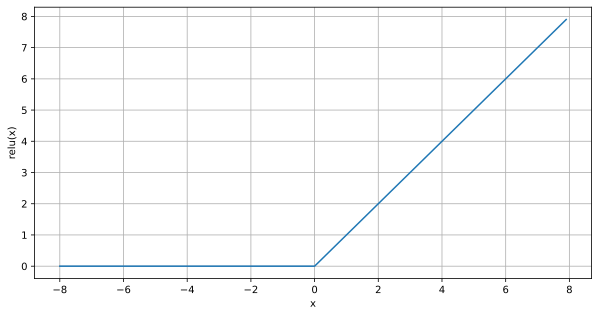

In [3]:
x = torch.arange(-8.0, 8.0, 0.1, requires_grad=True)
y = torch.relu(x)
d2l.plot(x.detach(), y.detach(), 'x', 'relu(x)', figsize=(10, 5))

When the input is negative,
the derivative of the ReLU function is 0,
and when the input is positive,
the derivative of the ReLU function is 1.
Note that the ReLU function is not differentiable
when the input takes value precisely equal to 0.
In these cases, we default to the left-hand-side
derivative and say that the derivative is 0 when the input is 0.
We can get away with this because
the input may never actually be zero (mathematicians would 
say that it's nondifferentiable on a set of measure zero).
There is an old adage that if subtle boundary conditions matter,
we are probably doing (*real*) mathematics, not engineering.
That conventional wisdom may apply here, or at least, the fact that 
we are not performing constrained optimization :cite:`Mangasarian.1965,Rockafellar.1970`. 
We plot the derivative of the ReLU function plotted below.

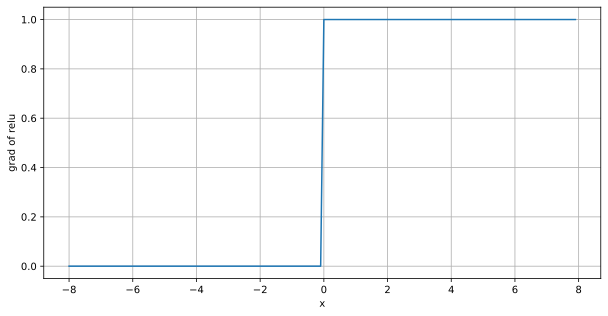

In [5]:
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of relu', figsize=(10, 5))

The reason for using ReLU is that
its derivatives are particularly well behaved:
either they vanish or they just let the argument through.
This makes optimization better behaved
and it mitigated the well-documented problem
of vanishing gradients that plagued
previous versions of neural networks (more on this later).

Note that there are many variants to the ReLU function,
including the *parameterized ReLU* (*pReLU*) function :cite:`He.Zhang.Ren.ea.2015`.
This variation adds a linear term to ReLU,
so some information still gets through,
even when the argument is negative:

$$\operatorname{pReLU}(x) = \max(0, x) + \alpha \min(0, x).$$

### Sigmoid Function

[**The *sigmoid function* transforms its inputs**],
for which values lie in the domain $\mathbb{R}$,
(**to outputs that lie on the interval (0, 1).**)
For that reason, the sigmoid is
often called a *squashing function*:
it squashes any input in the range (-inf, inf)
to some value in the range (0, 1):

$$\operatorname{sigmoid}(x) = \frac{1}{1 + \exp(-x)}.$$

In the earliest neural networks, scientists
were interested in modeling biological neurons
which either *fire* or *do not fire*.
Thus the pioneers of this field,
going all the way back to McCulloch and Pitts,
the inventors of the artificial neuron,
focused on thresholding units :cite:`McCulloch.Pitts.1943`.
A thresholding activation takes value 0
when its input is below some threshold
and value 1 when the input exceeds the threshold.

When attention shifted to gradient based learning,
the sigmoid function was a natural choice
because it is a smooth, differentiable
approximation to a thresholding unit.
Sigmoids are still widely used as
activation functions on the output units,
when we want to interpret the outputs as probabilities
for binary classification problems: you can think of the sigmoid as a special case of the softmax.
However, the sigmoid has mostly been replaced
by the simpler and more easily trainable ReLU
for most use in hidden layers. Much of this has to do 
with the fact that the sigmoid poses challenges for optimization
:cite:`LeCun.Bottou.Orr.ea.1998` since its gradient vanishes for large positive *and* negative arguments. 
This can lead to plateaus that are difficult to escape from. 
Nonetheless sigmoids are important. In later chapters (e.g., :numref:`sec_lstm`) on recurrent neural networks,
we will describe architectures that leverage sigmoid units
to control the flow of information across time.

Below, we plot the sigmoid function.
Note that when the input is close to 0,
the sigmoid function approaches
a linear transformation.

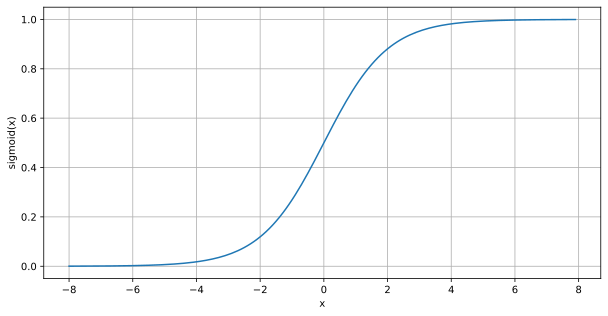

In [6]:
y = torch.sigmoid(x)
d2l.plot(x.detach(), y.detach(), 'x', 'sigmoid(x)' , figsize=(10, 5))

The derivative of the sigmoid function is given by the following equation:

$$\frac{d}{dx} \operatorname{sigmoid}(x) = \frac{\exp(-x)}{(1 + \exp(-x))^2} = \operatorname{sigmoid}(x)\left(1-\operatorname{sigmoid}(x)\right).$$


The derivative of the sigmoid function is plotted below.
Note that when the input is 0,
the derivative of the sigmoid function
reaches a maximum of 0.25.
As the input diverges from 0 in either direction,
the derivative approaches 0.

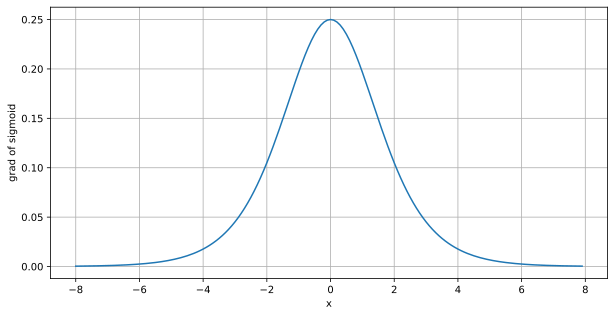

In [8]:
x.grad.data.zero_()
y.backward(torch.ones_like(x), retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of sigmoid', figsize=(10, 5))

### Tanh Function

Like the sigmoid function, [**the tanh (hyperbolic tangent)
function also squashes its inputs**],
transforming them into elements on the interval (**between -1 and 1**):

$$\operatorname{tanh}(x) = \frac{1 - \exp(-2x)}{1 + \exp(-2x)}.$$

We plot the tanh function below. Note that as input nears 0, the tanh function approaches a linear transformation. Although the shape of the function is similar to that of the sigmoid function, the tanh function exhibits point symmetry about the origin of the coordinate system :cite:`Kalman.Kwasny.1992`.

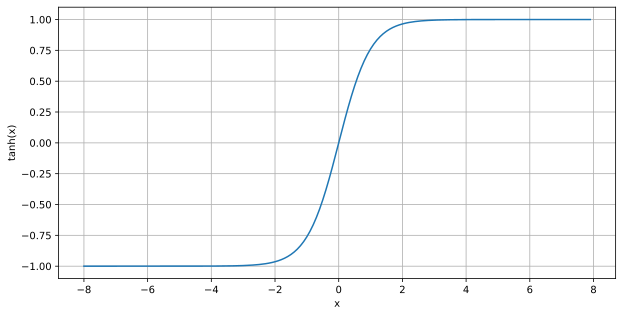

In [9]:
y = torch.tanh(x)
d2l.plot(x.detach(), y.detach(), 'x', 'tanh(x)', figsize=(10, 5))

The derivative of the tanh function is:

$$\frac{d}{dx} \operatorname{tanh}(x) = 1 - \operatorname{tanh}^2(x).$$

It is plotted below.
As the input nears 0,
the derivative of the tanh function approaches a maximum of 1.
And as we saw with the sigmoid function,
as input moves away from 0 in either direction,
the derivative of the tanh function approaches 0.

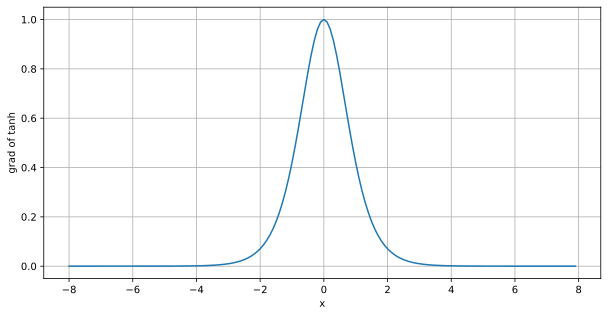

In [13]:
x.grad.data.zero_()
y.backward(torch.ones_like(x),retain_graph=True)
d2l.plot(x.detach(), x.grad, 'x', 'grad of tanh', figsize=(10, 5))

## Summary

We now know how to incorporate nonlinearities
to build expressive multilayer neural network architectures.
As a side note, your knowledge already
puts you in command of a similar toolkit
to a practitioner circa 1990.
In some ways, you have an advantage
over anyone working in the 1990s,
because you can leverage powerful
open-source deep learning frameworks
to build models rapidly, using only a few lines of code.
Previously, training these networks
required researchers to code up layers and derivatives
explicitly in C, Fortran, or even Lisp (in the case of LeNet). 

A secondary benefit is that ReLU is significantly more amenable to
optimization than the sigmoid or the tanh function. One could argue 
that this was one of the key innovations that helped the resurgence
of deep learning over the past decade. Note, though, that research in 
activation functions has not stopped. For instance, the Swish activation 
function $\sigma(x) = x \operatorname{sigmoid}(\beta x)$ as proposed in
:cite:`Ramachandran.Zoph.Le.2017` can yield better accuracy 
in many cases.

## Exercises

1. Show that adding layers to a *linear* deep network, i.e., a network without 
   nonlinearity $\sigma$ can never increase the expressive power of the network. 
   Give an example where it actively reduces it. 
1. Compute the derivative of the pReLU activation function.
1. Compute the derivative of the Swish activation function $x \operatorname{sigmoid}(\beta x)$. 
1. Show that an MLP using only ReLU (or pReLU) constructs a 
   continuous piecewise linear function.
1. Sigmoid and tanh are very similar. 
    1. Show that $\operatorname{tanh}(x) + 1 = 2 \operatorname{sigmoid}(2x)$.
    1. Prove that the function classes parametrized by both nonlinearities are identical. Hint: affine layers have bias terms, too.
1. Assume that we have a nonlinearity that applies to one minibatch at a time, such as the batch normalization :cite:`Ioffe.Szegedy.2015`. What kinds of problems do you expect this to cause?
1. Provide an example where the gradients vanish for the sigmoid activation function. 

:begin_tab:`mxnet`
[Discussions](https://discuss.d2l.ai/t/90)
:end_tab:

:begin_tab:`pytorch`
[Discussions](https://discuss.d2l.ai/t/91)
:end_tab:

:begin_tab:`tensorflow`
[Discussions](https://discuss.d2l.ai/t/226)
:end_tab: